### Question 1
Train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce roughly the same model.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris["data"][:,(2,3)] # pedal length, pedal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [3]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scaled_X = scale.fit_transform(X)

C = 5
alpha = 1 / (C * len(X))

lin_svc = LinearSVC(loss="hinge", C=C, random_state=42)
svc_clf = SVC(kernel="linear", C=C, random_state=42)
sgd_clf = SGDClassifier(loss="hinge", n_iter=100000, alpha=alpha, random_state=42)
log_clf = SGDClassifier(loss="log", n_iter=1000, alpha=alpha, random_state=42)
for clf in (lin_svc, svc_clf, sgd_clf, log_clf):
    clf.fit(scaled_X, y)
    print(clf.__class__.__name__, clf.coef_, clf.intercept_)

LinearSVC [[ 1.05541976  1.09851597]] [ 0.28481447]
SVC [[ 1.1223101   1.02531081]] [ 0.31933577]
SGDClassifier [[ 1.12235762  1.02535233]] [ 0.31931571]
SGDClassifier [[ 3.01628544  2.87054994]] [ 0.64790489]


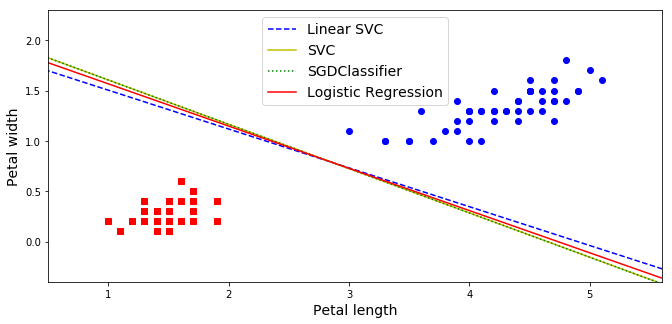

In [6]:
def plot_decision_bounday(clf, style, label):
    w = clf.coef_[0]
    b = clf.intercept_[0]
    
    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    decision_boundary = scale.inverse_transform([[-10, 10*w[0]/w[1] + b/w[1]],[10, -10*w[0]/w[1] - b/w[1]]])
    plt.plot(decision_boundary[:,0], decision_boundary[:,1], style, label=label)

fig = plt.figure(figsize=(11, 5))
plt.plot(X[:,0][y==1], X[:,1][y==1], "bo")
plt.plot(X[:,0][y==0], X[:,1][y==0], "rs")
plot_decision_bounday(lin_svc, "b--", "Linear SVC")
plot_decision_bounday(svc_clf, "y-", "SVC")
plot_decision_bounday(sgd_clf, "g:", "SGDClassifier")
plot_decision_bounday(log_clf, "r-", "Logistic Regression")
plt.axis([np.min(X[:, 0]) -.5, np.max(X[:,0]) + .5, np.min(X[:,1]) - .5, np.max(X[:,1]) + .5])
plt.legend(loc="upper center", fontsize=14)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.show()

### Question 2
Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?_

In [7]:
# load dadta 
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import StandardScaler
mnist = fetch_mldata('MNIST original', data_home='datasets/mnist')
X = mnist["data"]
y = mnist["target"]
X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [8]:
np.random.seed(41)
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]
X_train_scaled = StandardScaler().fit_transform(X_train.astype(np.float32))
X_test_scaled = StandardScaler().fit_transform(X_test.astype(np.float32))

In [9]:
# Linear SVC
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(lin_clf.predict(X_test_scaled), y_test)

0.90969999999999995

In [11]:
# applying a kernel
svm_clf = SVC(decision_function_shape="ovr")
svm_clf.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
accuracy_score(svm_clf.predict(X_test_scaled), y_test)

0.9657

In [13]:
# Search for best parameters
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
svm_clf = SVC(decision_function_shape="ovr")
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, cv=3, n_iter = 5, verbose=4, n_jobs=-1, scoring="accuracy")
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    6.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    7.3s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000014DF58D4D68>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000014DF58B9630>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=4)

In [14]:
rnd_search_cv.best_estimator_

SVC(C=1.798000830751896, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0011838423212249195,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [15]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=1.798000830751896, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0011838423212249195,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(rnd_search_cv.best_estimator_.predict(X_test_scaled), y_test) 

0.96899999999999997

### Question 3
Train an SVM regressor on the California housing dataset.

In [21]:
# fetch the data
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

In [22]:
X.shape

(20640, 8)

In [25]:
housing["feature_names"]

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [30]:
from sklearn.model_selection import train_test_split
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
print(X_train.shape, X_test.shape)

(14448, 8) (6192, 8)


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)
lin_svr = LinearSVR(random_state=40)
lin_svr.fit(X_train_scaled, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=40, tol=0.0001, verbose=0)

In [35]:
from sklearn.metrics import mean_squared_error
pred_y = lin_svr.predict(X_test_scaled)
print("RMSE", np.sqrt(mean_squared_error(pred_y, y_test)))

RMSE 1.18463060186


In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import reciprocal, uniform
params_dist = {"C": np.linspace(1,10,5), "gamma": reciprocal(0.001, 0.1)}
rnd_search_cv = RandomizedSearchCV(SVR(), params_dist, cv=4, n_jobs=-1, n_iter=5, verbose=4, scoring="neg_mean_")
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   57.4s finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'C': array([  1.  ,   3.25,   5.5 ,   7.75,  10.  ]), 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000014D81860F98>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=4)

In [50]:
rnd_search_cv.best_estimator_

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.030935880352345554, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
# RMSE on the training set
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
print("RMSE on training set", np.sqrt(mean_squared_error(y_train, y_pred)))

RMSE on training set 0.601759310616


In [54]:
# RMSE on testing set
y_pred_test = rnd_search_cv.best_estimator_.predict(X_test_scaled)
print("RMSE on test set", np.sqrt(mean_squared_error(y_test, y_pred_test)))

RMSE on test set 0.61040786477
